##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

   16384/68606236 [..............................] - ETA: 0s

 4202496/68606236 [>.............................] - ETA: 5s

13541376/68606236 [====>.........................] - ETA: 1s

23175168/68606236 [=========>....................] - ETA: 0s

33562624/68606236 [=============>................] - ETA: 0s

41418752/68606236 [=================>............] - ETA: 0s

52256768/68606236 [=====================>........] - ETA: 0s

60997632/68606236 [=========================>....] - ETA: 0s

68608000/68606236 [==============================] - 1s 0us/step


68616192/68606236 [==============================] - 1s 0us/step


Found 2000 files belonging to 2 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

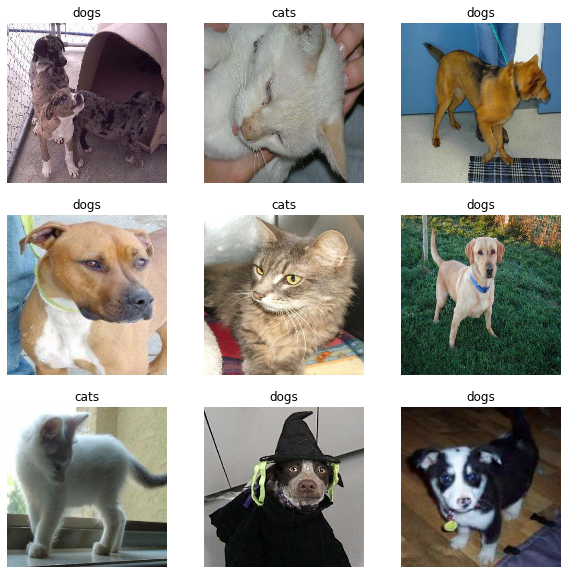

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate` or `Model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

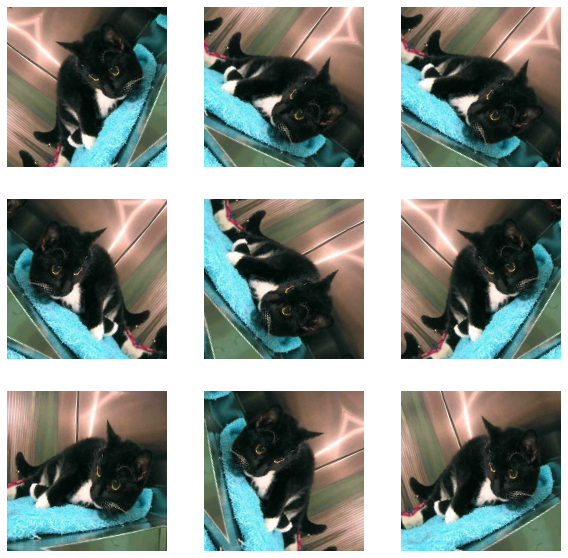

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [13]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

  16384/9406464 [..............................] - ETA: 0s

7323648/9406464 [======================>.......] - ETA: 0s

9412608/9406464 [==============================] - 0s 0us/step


9420800/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [16]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         


 sequential (Sequential)     (None, 160, 160, 3)       0         


 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         


 )                                                               


 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         


 a)                                                              


 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   


 ional)                                                          


 global_average_pooling2d (G  (None, 1280)             0         


 lobalAveragePooling2D)                                          


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 1)                 1281      


Total params: 2,259,265


Trainable params: 1,281


Non-trainable params: 2,257,984


_________________________________________________________________


The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [23]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

 1/26 [>.............................] - ETA: 37s - loss: 0.7595 - accuracy: 0.5312

 5/26 [====>.........................] - ETA: 0s - loss: 0.7404 - accuracy: 0.4750 

 9/26 [=========>....................] - ETA: 0s - loss: 0.7427 - accuracy: 0.4896

13/26 [==============>...............] - ETA: 0s - loss: 0.7390 - accuracy: 0.5072

17/26 [==================>...........] - ETA: 0s - loss: 0.7412 - accuracy: 0.5147

22/26 [========================>.....] - ETA: 0s - loss: 0.7434 - accuracy: 0.5213

26/26 [==============================] - ETA: 0s - loss: 0.7428 - accuracy: 0.5186

26/26 [==============================] - 2s 16ms/step - loss: 0.7428 - accuracy: 0.5186


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.74
initial accuracy: 0.52


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


 1/63 [..............................] - ETA: 2:32 - loss: 0.7767 - accuracy: 0.5625

 5/63 [=>............................] - ETA: 0s - loss: 0.8012 - accuracy: 0.4563  

 9/63 [===>..........................] - ETA: 0s - loss: 0.7794 - accuracy: 0.4826

13/63 [=====>........................] - ETA: 0s - loss: 0.7541 - accuracy: 0.5048

17/63 [=======>......................] - ETA: 0s - loss: 0.7281 - accuracy: 0.5276

21/63 [=========>....................] - ETA: 0s - loss: 0.7228 - accuracy: 0.5402

25/63 [==========>...................] - ETA: 0s - loss: 0.7225 - accuracy: 0.5462

29/63 [============>.................] - ETA: 0s - loss: 0.7283 - accuracy: 0.5420

33/63 [==============>...............] - ETA: 0s - loss: 0.7264 - accuracy: 0.5445

37/63 [================>.............] - ETA: 0s - loss: 0.7205 - accuracy: 0.5524

41/63 [==================>...........] - ETA: 0s - loss: 0.7106 - accuracy: 0.5610

45/63 [====================>.........] - ETA: 0s - loss: 0.7053 - accuracy: 0.5611

49/63 [======================>.......] - ETA: 0s - loss: 0.6972 - accuracy: 0.5663

53/63 [========================>.....] - ETA: 0s - loss: 0.6920 - accuracy: 0.5643

57/63 [==========================>...] - ETA: 0s - loss: 0.6861 - accuracy: 0.5680

61/63 [============================>.] - ETA: 0s - loss: 0.6827 - accuracy: 0.5681

63/63 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.5680

63/63 [==============================] - 4s 23ms/step - loss: 0.6804 - accuracy: 0.5680 - val_loss: 0.4981 - val_accuracy: 0.7054


Epoch 2/10


 1/63 [..............................] - ETA: 5s - loss: 0.6439 - accuracy: 0.6250

 5/63 [=>............................] - ETA: 0s - loss: 0.6217 - accuracy: 0.6000

 9/63 [===>..........................] - ETA: 0s - loss: 0.6162 - accuracy: 0.6319

13/63 [=====>........................] - ETA: 0s - loss: 0.6015 - accuracy: 0.6490

17/63 [=======>......................] - ETA: 0s - loss: 0.5736 - accuracy: 0.6710

21/63 [=========>....................] - ETA: 0s - loss: 0.5652 - accuracy: 0.6726

25/63 [==========>...................] - ETA: 0s - loss: 0.5610 - accuracy: 0.6687

29/63 [============>.................] - ETA: 0s - loss: 0.5483 - accuracy: 0.6821

33/63 [==============>...............] - ETA: 0s - loss: 0.5421 - accuracy: 0.6913

37/63 [================>.............] - ETA: 0s - loss: 0.5332 - accuracy: 0.7002

41/63 [==================>...........] - ETA: 0s - loss: 0.5238 - accuracy: 0.7058

45/63 [====================>.........] - ETA: 0s - loss: 0.5205 - accuracy: 0.7097

49/63 [======================>.......] - ETA: 0s - loss: 0.5185 - accuracy: 0.7098

53/63 [========================>.....] - ETA: 0s - loss: 0.5130 - accuracy: 0.7146

57/63 [==========================>...] - ETA: 0s - loss: 0.5084 - accuracy: 0.7155

61/63 [============================>.] - ETA: 0s - loss: 0.5065 - accuracy: 0.7177

63/63 [==============================] - 1s 22ms/step - loss: 0.5044 - accuracy: 0.7170 - val_loss: 0.3598 - val_accuracy: 0.8144


Epoch 3/10


 1/63 [..............................] - ETA: 5s - loss: 0.3598 - accuracy: 0.7500

 5/63 [=>............................] - ETA: 0s - loss: 0.4337 - accuracy: 0.7500

 9/63 [===>..........................] - ETA: 0s - loss: 0.4600 - accuracy: 0.7326

13/63 [=====>........................] - ETA: 0s - loss: 0.4563 - accuracy: 0.7308

17/63 [=======>......................] - ETA: 0s - loss: 0.4473 - accuracy: 0.7445

21/63 [=========>....................] - ETA: 0s - loss: 0.4430 - accuracy: 0.7470

25/63 [==========>...................] - ETA: 0s - loss: 0.4446 - accuracy: 0.7437

29/63 [============>.................] - ETA: 0s - loss: 0.4426 - accuracy: 0.7446

33/63 [==============>...............] - ETA: 0s - loss: 0.4333 - accuracy: 0.7538

37/63 [================>.............] - ETA: 0s - loss: 0.4330 - accuracy: 0.7601

41/63 [==================>...........] - ETA: 0s - loss: 0.4308 - accuracy: 0.7645

45/63 [====================>.........] - ETA: 0s - loss: 0.4247 - accuracy: 0.7729

49/63 [======================>.......] - ETA: 0s - loss: 0.4215 - accuracy: 0.7749

53/63 [========================>.....] - ETA: 0s - loss: 0.4176 - accuracy: 0.7807

57/63 [==========================>...] - ETA: 0s - loss: 0.4147 - accuracy: 0.7796

61/63 [============================>.] - ETA: 0s - loss: 0.4111 - accuracy: 0.7838

63/63 [==============================] - 1s 21ms/step - loss: 0.4109 - accuracy: 0.7845 - val_loss: 0.2810 - val_accuracy: 0.8861


Epoch 4/10


 1/63 [..............................] - ETA: 5s - loss: 0.3441 - accuracy: 0.9062

 5/63 [=>............................] - ETA: 0s - loss: 0.3487 - accuracy: 0.8438

 9/63 [===>..........................] - ETA: 0s - loss: 0.3095 - accuracy: 0.8750

13/63 [=====>........................] - ETA: 0s - loss: 0.3214 - accuracy: 0.8510

17/63 [=======>......................] - ETA: 0s - loss: 0.3293 - accuracy: 0.8456

21/63 [=========>....................] - ETA: 0s - loss: 0.3342 - accuracy: 0.8408

25/63 [==========>...................] - ETA: 0s - loss: 0.3385 - accuracy: 0.8425

29/63 [============>.................] - ETA: 0s - loss: 0.3382 - accuracy: 0.8459

33/63 [==============>...............] - ETA: 0s - loss: 0.3389 - accuracy: 0.8419

37/63 [================>.............] - ETA: 0s - loss: 0.3339 - accuracy: 0.8463

41/63 [==================>...........] - ETA: 0s - loss: 0.3318 - accuracy: 0.8460

45/63 [====================>.........] - ETA: 0s - loss: 0.3344 - accuracy: 0.8451

49/63 [======================>.......] - ETA: 0s - loss: 0.3311 - accuracy: 0.8457

53/63 [========================>.....] - ETA: 0s - loss: 0.3277 - accuracy: 0.8473

57/63 [==========================>...] - ETA: 0s - loss: 0.3270 - accuracy: 0.8476

61/63 [============================>.] - ETA: 0s - loss: 0.3271 - accuracy: 0.8463

63/63 [==============================] - 1s 21ms/step - loss: 0.3285 - accuracy: 0.8445 - val_loss: 0.2256 - val_accuracy: 0.9208


Epoch 5/10


 1/63 [..............................] - ETA: 5s - loss: 0.2201 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.3062 - accuracy: 0.8500

 9/63 [===>..........................] - ETA: 0s - loss: 0.3271 - accuracy: 0.8472

13/63 [=====>........................] - ETA: 0s - loss: 0.3163 - accuracy: 0.8582

17/63 [=======>......................] - ETA: 0s - loss: 0.3194 - accuracy: 0.8529

21/63 [=========>....................] - ETA: 0s - loss: 0.3256 - accuracy: 0.8438

25/63 [==========>...................] - ETA: 0s - loss: 0.3261 - accuracy: 0.8450

29/63 [============>.................] - ETA: 0s - loss: 0.3246 - accuracy: 0.8470

33/63 [==============>...............] - ETA: 0s - loss: 0.3204 - accuracy: 0.8513

37/63 [================>.............] - ETA: 0s - loss: 0.3231 - accuracy: 0.8522

41/63 [==================>...........] - ETA: 0s - loss: 0.3186 - accuracy: 0.8544

45/63 [====================>.........] - ETA: 0s - loss: 0.3133 - accuracy: 0.8597

49/63 [======================>.......] - ETA: 0s - loss: 0.3136 - accuracy: 0.8584

53/63 [========================>.....] - ETA: 0s - loss: 0.3145 - accuracy: 0.8544

57/63 [==========================>...] - ETA: 0s - loss: 0.3116 - accuracy: 0.8547

61/63 [============================>.] - ETA: 0s - loss: 0.3121 - accuracy: 0.8545

63/63 [==============================] - 1s 21ms/step - loss: 0.3108 - accuracy: 0.8555 - val_loss: 0.1986 - val_accuracy: 0.9307


Epoch 6/10


 1/63 [..............................] - ETA: 5s - loss: 0.1984 - accuracy: 0.9062

 4/63 [>.............................] - ETA: 1s - loss: 0.2571 - accuracy: 0.8828

 8/63 [==>...........................] - ETA: 0s - loss: 0.2776 - accuracy: 0.8867

12/63 [====>.........................] - ETA: 0s - loss: 0.3039 - accuracy: 0.8672

16/63 [======>.......................] - ETA: 0s - loss: 0.2953 - accuracy: 0.8730

20/63 [========>.....................] - ETA: 0s - loss: 0.2971 - accuracy: 0.8703

24/63 [==========>...................] - ETA: 0s - loss: 0.2895 - accuracy: 0.8698

28/63 [============>.................] - ETA: 0s - loss: 0.2904 - accuracy: 0.8717

32/63 [==============>...............] - ETA: 0s - loss: 0.2932 - accuracy: 0.8662

36/63 [================>.............] - ETA: 0s - loss: 0.2901 - accuracy: 0.8724

40/63 [==================>...........] - ETA: 0s - loss: 0.2881 - accuracy: 0.8742

44/63 [===================>..........] - ETA: 0s - loss: 0.2821 - accuracy: 0.8793

48/63 [=====================>........] - ETA: 0s - loss: 0.2768 - accuracy: 0.8835

52/63 [=======================>......] - ETA: 0s - loss: 0.2723 - accuracy: 0.8852

56/63 [=========================>....] - ETA: 0s - loss: 0.2699 - accuracy: 0.8856

60/63 [===========================>..] - ETA: 0s - loss: 0.2689 - accuracy: 0.8844

63/63 [==============================] - 1s 21ms/step - loss: 0.2659 - accuracy: 0.8855 - val_loss: 0.1703 - val_accuracy: 0.9418


Epoch 7/10


 1/63 [..............................] - ETA: 5s - loss: 0.2462 - accuracy: 0.8750

 5/63 [=>............................] - ETA: 0s - loss: 0.2377 - accuracy: 0.8875

 9/63 [===>..........................] - ETA: 0s - loss: 0.2421 - accuracy: 0.8958

13/63 [=====>........................] - ETA: 0s - loss: 0.2582 - accuracy: 0.8894

17/63 [=======>......................] - ETA: 0s - loss: 0.2789 - accuracy: 0.8658

21/63 [=========>....................] - ETA: 0s - loss: 0.2730 - accuracy: 0.8720

25/63 [==========>...................] - ETA: 0s - loss: 0.2650 - accuracy: 0.8800

29/63 [============>.................] - ETA: 0s - loss: 0.2602 - accuracy: 0.8825

33/63 [==============>...............] - ETA: 0s - loss: 0.2597 - accuracy: 0.8873

37/63 [================>.............] - ETA: 0s - loss: 0.2585 - accuracy: 0.8877

41/63 [==================>...........] - ETA: 0s - loss: 0.2565 - accuracy: 0.8902

45/63 [====================>.........] - ETA: 0s - loss: 0.2556 - accuracy: 0.8903

49/63 [======================>.......] - ETA: 0s - loss: 0.2529 - accuracy: 0.8922

53/63 [========================>.....] - ETA: 0s - loss: 0.2486 - accuracy: 0.8939

57/63 [==========================>...] - ETA: 0s - loss: 0.2460 - accuracy: 0.8947

61/63 [============================>.] - ETA: 0s - loss: 0.2474 - accuracy: 0.8929

63/63 [==============================] - 1s 21ms/step - loss: 0.2459 - accuracy: 0.8935 - val_loss: 0.1495 - val_accuracy: 0.9517


Epoch 8/10


 1/63 [..............................] - ETA: 5s - loss: 0.2409 - accuracy: 0.8750

 5/63 [=>............................] - ETA: 0s - loss: 0.2482 - accuracy: 0.9062

 9/63 [===>..........................] - ETA: 0s - loss: 0.2559 - accuracy: 0.8993

13/63 [=====>........................] - ETA: 0s - loss: 0.2558 - accuracy: 0.8990

17/63 [=======>......................] - ETA: 0s - loss: 0.2508 - accuracy: 0.8934

21/63 [=========>....................] - ETA: 0s - loss: 0.2474 - accuracy: 0.8943

25/63 [==========>...................] - ETA: 0s - loss: 0.2487 - accuracy: 0.8900

29/63 [============>.................] - ETA: 0s - loss: 0.2463 - accuracy: 0.8944

33/63 [==============>...............] - ETA: 0s - loss: 0.2475 - accuracy: 0.8939

37/63 [================>.............] - ETA: 0s - loss: 0.2438 - accuracy: 0.8953

41/63 [==================>...........] - ETA: 0s - loss: 0.2379 - accuracy: 0.8963

45/63 [====================>.........] - ETA: 0s - loss: 0.2353 - accuracy: 0.8965

49/63 [======================>.......] - ETA: 0s - loss: 0.2320 - accuracy: 0.8980

53/63 [========================>.....] - ETA: 0s - loss: 0.2293 - accuracy: 0.8980

57/63 [==========================>...] - ETA: 0s - loss: 0.2313 - accuracy: 0.8975

61/63 [============================>.] - ETA: 0s - loss: 0.2315 - accuracy: 0.8955

63/63 [==============================] - 1s 21ms/step - loss: 0.2315 - accuracy: 0.8950 - val_loss: 0.1454 - val_accuracy: 0.9542


Epoch 9/10


 1/63 [..............................] - ETA: 5s - loss: 0.2685 - accuracy: 0.8750

 5/63 [=>............................] - ETA: 0s - loss: 0.2013 - accuracy: 0.9187

 9/63 [===>..........................] - ETA: 0s - loss: 0.2409 - accuracy: 0.8924

13/63 [=====>........................] - ETA: 0s - loss: 0.2559 - accuracy: 0.8894

17/63 [=======>......................] - ETA: 0s - loss: 0.2575 - accuracy: 0.8860

21/63 [=========>....................] - ETA: 0s - loss: 0.2467 - accuracy: 0.8869

25/63 [==========>...................] - ETA: 0s - loss: 0.2389 - accuracy: 0.8888

29/63 [============>.................] - ETA: 0s - loss: 0.2375 - accuracy: 0.8955

33/63 [==============>...............] - ETA: 0s - loss: 0.2351 - accuracy: 0.8987

37/63 [================>.............] - ETA: 0s - loss: 0.2323 - accuracy: 0.9029

41/63 [==================>...........] - ETA: 0s - loss: 0.2294 - accuracy: 0.9032

45/63 [====================>.........] - ETA: 0s - loss: 0.2233 - accuracy: 0.9049

49/63 [======================>.......] - ETA: 0s - loss: 0.2215 - accuracy: 0.9069

53/63 [========================>.....] - ETA: 0s - loss: 0.2200 - accuracy: 0.9057

57/63 [==========================>...] - ETA: 0s - loss: 0.2191 - accuracy: 0.9057

61/63 [============================>.] - ETA: 0s - loss: 0.2215 - accuracy: 0.9037

63/63 [==============================] - 1s 21ms/step - loss: 0.2204 - accuracy: 0.9030 - val_loss: 0.1326 - val_accuracy: 0.9592


Epoch 10/10


 1/63 [..............................] - ETA: 5s - loss: 0.1350 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.1887 - accuracy: 0.9250

 9/63 [===>..........................] - ETA: 0s - loss: 0.2369 - accuracy: 0.9028

13/63 [=====>........................] - ETA: 0s - loss: 0.2365 - accuracy: 0.9014

17/63 [=======>......................] - ETA: 0s - loss: 0.2507 - accuracy: 0.8934

21/63 [=========>....................] - ETA: 0s - loss: 0.2346 - accuracy: 0.9018

25/63 [==========>...................] - ETA: 0s - loss: 0.2374 - accuracy: 0.9025

29/63 [============>.................] - ETA: 0s - loss: 0.2333 - accuracy: 0.9095

33/63 [==============>...............] - ETA: 0s - loss: 0.2261 - accuracy: 0.9129

37/63 [================>.............] - ETA: 0s - loss: 0.2280 - accuracy: 0.9130

41/63 [==================>...........] - ETA: 0s - loss: 0.2234 - accuracy: 0.9139

45/63 [====================>.........] - ETA: 0s - loss: 0.2209 - accuracy: 0.9139

49/63 [======================>.......] - ETA: 0s - loss: 0.2264 - accuracy: 0.9094

53/63 [========================>.....] - ETA: 0s - loss: 0.2214 - accuracy: 0.9133

57/63 [==========================>...] - ETA: 0s - loss: 0.2218 - accuracy: 0.9106

61/63 [============================>.] - ETA: 0s - loss: 0.2206 - accuracy: 0.9098

63/63 [==============================] - 1s 21ms/step - loss: 0.2180 - accuracy: 0.9115 - val_loss: 0.1215 - val_accuracy: 0.9604


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

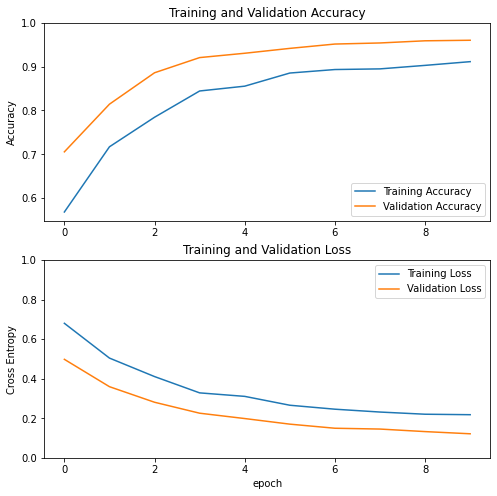

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         


 sequential (Sequential)     (None, 160, 160, 3)       0         


 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         


 )                                                               


 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         


 a)                                                              


 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   


 ional)                                                          


 global_average_pooling2d (G  (None, 1280)             0         


 lobalAveragePooling2D)                                          


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 1)                 1281      


Total params: 2,259,265


Trainable params: 1,862,721


Non-trainable params: 396,544


_________________________________________________________________


In [32]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


 1/63 [..............................] - ETA: 4:36 - loss: 0.2464 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 1s - loss: 0.2399 - accuracy: 0.9062  

 6/63 [=>............................] - ETA: 1s - loss: 0.2281 - accuracy: 0.8854

 9/63 [===>..........................] - ETA: 1s - loss: 0.1913 - accuracy: 0.9097

12/63 [====>.........................] - ETA: 1s - loss: 0.1953 - accuracy: 0.9115

15/63 [======>.......................] - ETA: 1s - loss: 0.1970 - accuracy: 0.9062

18/63 [=======>......................] - ETA: 1s - loss: 0.1870 - accuracy: 0.9132

21/63 [=========>....................] - ETA: 0s - loss: 0.1882 - accuracy: 0.9122

24/63 [==========>...................] - ETA: 0s - loss: 0.1816 - accuracy: 0.9141

27/63 [===========>..................] - ETA: 0s - loss: 0.1754 - accuracy: 0.9201

30/63 [=============>................] - ETA: 0s - loss: 0.1706 - accuracy: 0.9240

33/63 [==============>...............] - ETA: 0s - loss: 0.1698 - accuracy: 0.9223

36/63 [================>.............] - ETA: 0s - loss: 0.1625 - accuracy: 0.9262

39/63 [=================>............] - ETA: 0s - loss: 0.1676 - accuracy: 0.9231

42/63 [===================>..........] - ETA: 0s - loss: 0.1623 - accuracy: 0.9263

45/63 [====================>.........] - ETA: 0s - loss: 0.1697 - accuracy: 0.9257

48/63 [=====================>........] - ETA: 0s - loss: 0.1647 - accuracy: 0.9284

51/63 [=======================>......] - ETA: 0s - loss: 0.1634 - accuracy: 0.9289

54/63 [========================>.....] - ETA: 0s - loss: 0.1644 - accuracy: 0.9288

57/63 [==========================>...] - ETA: 0s - loss: 0.1628 - accuracy: 0.9293

60/63 [===========================>..] - ETA: 0s - loss: 0.1575 - accuracy: 0.9318

63/63 [==============================] - ETA: 0s - loss: 0.1545 - accuracy: 0.9335

63/63 [==============================] - 7s 40ms/step - loss: 0.1545 - accuracy: 0.9335 - val_loss: 0.0531 - val_accuracy: 0.9864


Epoch 11/20


 1/63 [..............................] - ETA: 5s - loss: 0.0316 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.0640 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 1s - loss: 0.1101 - accuracy: 0.9643

10/63 [===>..........................] - ETA: 1s - loss: 0.1232 - accuracy: 0.9531

13/63 [=====>........................] - ETA: 1s - loss: 0.1244 - accuracy: 0.9543

16/63 [======>.......................] - ETA: 1s - loss: 0.1196 - accuracy: 0.9551

19/63 [========>.....................] - ETA: 0s - loss: 0.1158 - accuracy: 0.9572

22/63 [=========>....................] - ETA: 0s - loss: 0.1193 - accuracy: 0.9560

25/63 [==========>...................] - ETA: 0s - loss: 0.1154 - accuracy: 0.9575

28/63 [============>.................] - ETA: 0s - loss: 0.1239 - accuracy: 0.9531

31/63 [=============>................] - ETA: 0s - loss: 0.1200 - accuracy: 0.9546

34/63 [===============>..............] - ETA: 0s - loss: 0.1255 - accuracy: 0.9531

37/63 [================>.............] - ETA: 0s - loss: 0.1251 - accuracy: 0.9510

40/63 [==================>...........] - ETA: 0s - loss: 0.1228 - accuracy: 0.9516

43/63 [===================>..........] - ETA: 0s - loss: 0.1173 - accuracy: 0.9535

46/63 [====================>.........] - ETA: 0s - loss: 0.1174 - accuracy: 0.9531

49/63 [======================>.......] - ETA: 0s - loss: 0.1118 - accuracy: 0.9560

52/63 [=======================>......] - ETA: 0s - loss: 0.1141 - accuracy: 0.9543

55/63 [=========================>....] - ETA: 0s - loss: 0.1135 - accuracy: 0.9551

58/63 [==========================>...] - ETA: 0s - loss: 0.1188 - accuracy: 0.9531

61/63 [============================>.] - ETA: 0s - loss: 0.1177 - accuracy: 0.9534

63/63 [==============================] - 2s 28ms/step - loss: 0.1161 - accuracy: 0.9540 - val_loss: 0.0500 - val_accuracy: 0.9814


Epoch 12/20


 1/63 [..............................] - ETA: 5s - loss: 0.2314 - accuracy: 0.9062

 4/63 [>.............................] - ETA: 1s - loss: 0.0825 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 1s - loss: 0.0684 - accuracy: 0.9732

10/63 [===>..........................] - ETA: 1s - loss: 0.0866 - accuracy: 0.9625

13/63 [=====>........................] - ETA: 1s - loss: 0.1070 - accuracy: 0.9471

16/63 [======>.......................] - ETA: 1s - loss: 0.1018 - accuracy: 0.9531

19/63 [========>.....................] - ETA: 0s - loss: 0.1118 - accuracy: 0.9490

22/63 [=========>....................] - ETA: 0s - loss: 0.1141 - accuracy: 0.9460

25/63 [==========>...................] - ETA: 0s - loss: 0.1130 - accuracy: 0.9500

28/63 [============>.................] - ETA: 0s - loss: 0.1174 - accuracy: 0.9520

31/63 [=============>................] - ETA: 0s - loss: 0.1159 - accuracy: 0.9516

34/63 [===============>..............] - ETA: 0s - loss: 0.1191 - accuracy: 0.9494

37/63 [================>.............] - ETA: 0s - loss: 0.1223 - accuracy: 0.9476

40/63 [==================>...........] - ETA: 0s - loss: 0.1167 - accuracy: 0.9492

43/63 [===================>..........] - ETA: 0s - loss: 0.1158 - accuracy: 0.9499

46/63 [====================>.........] - ETA: 0s - loss: 0.1155 - accuracy: 0.9490

49/63 [======================>.......] - ETA: 0s - loss: 0.1154 - accuracy: 0.9496

52/63 [=======================>......] - ETA: 0s - loss: 0.1159 - accuracy: 0.9477

55/63 [=========================>....] - ETA: 0s - loss: 0.1159 - accuracy: 0.9489

58/63 [==========================>...] - ETA: 0s - loss: 0.1150 - accuracy: 0.9504

61/63 [============================>.] - ETA: 0s - loss: 0.1123 - accuracy: 0.9524

63/63 [==============================] - 2s 28ms/step - loss: 0.1125 - accuracy: 0.9525 - val_loss: 0.0379 - val_accuracy: 0.9876


Epoch 13/20


 1/63 [..............................] - ETA: 5s - loss: 0.1223 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 1s - loss: 0.1070 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 1s - loss: 0.0884 - accuracy: 0.9688

10/63 [===>..........................] - ETA: 1s - loss: 0.0698 - accuracy: 0.9781

13/63 [=====>........................] - ETA: 1s - loss: 0.0914 - accuracy: 0.9663

16/63 [======>.......................] - ETA: 1s - loss: 0.0882 - accuracy: 0.9688

19/63 [========>.....................] - ETA: 0s - loss: 0.1037 - accuracy: 0.9638

22/63 [=========>....................] - ETA: 0s - loss: 0.1045 - accuracy: 0.9574

25/63 [==========>...................] - ETA: 0s - loss: 0.1027 - accuracy: 0.9575

28/63 [============>.................] - ETA: 0s - loss: 0.0985 - accuracy: 0.9598

31/63 [=============>................] - ETA: 0s - loss: 0.0932 - accuracy: 0.9627

34/63 [===============>..............] - ETA: 0s - loss: 0.0898 - accuracy: 0.9642

37/63 [================>.............] - ETA: 0s - loss: 0.0877 - accuracy: 0.9628

40/63 [==================>...........] - ETA: 0s - loss: 0.0891 - accuracy: 0.9625

43/63 [===================>..........] - ETA: 0s - loss: 0.0921 - accuracy: 0.9629

46/63 [====================>.........] - ETA: 0s - loss: 0.0937 - accuracy: 0.9606

49/63 [======================>.......] - ETA: 0s - loss: 0.0925 - accuracy: 0.9617

52/63 [=======================>......] - ETA: 0s - loss: 0.0880 - accuracy: 0.9639

55/63 [=========================>....] - ETA: 0s - loss: 0.0865 - accuracy: 0.9642

58/63 [==========================>...] - ETA: 0s - loss: 0.0862 - accuracy: 0.9639

61/63 [============================>.] - ETA: 0s - loss: 0.0894 - accuracy: 0.9626

63/63 [==============================] - 2s 28ms/step - loss: 0.0891 - accuracy: 0.9625 - val_loss: 0.0472 - val_accuracy: 0.9889


Epoch 14/20


 1/63 [..............................] - ETA: 5s - loss: 0.1501 - accuracy: 0.9375

 4/63 [>.............................] - ETA: 1s - loss: 0.1068 - accuracy: 0.9453

 7/63 [==>...........................] - ETA: 1s - loss: 0.0860 - accuracy: 0.9509

10/63 [===>..........................] - ETA: 1s - loss: 0.1161 - accuracy: 0.9469

13/63 [=====>........................] - ETA: 1s - loss: 0.1014 - accuracy: 0.9543

16/63 [======>.......................] - ETA: 1s - loss: 0.0962 - accuracy: 0.9551

19/63 [========>.....................] - ETA: 0s - loss: 0.0916 - accuracy: 0.9572

22/63 [=========>....................] - ETA: 0s - loss: 0.0943 - accuracy: 0.9588

25/63 [==========>...................] - ETA: 0s - loss: 0.0900 - accuracy: 0.9625

28/63 [============>.................] - ETA: 0s - loss: 0.0871 - accuracy: 0.9643

31/63 [=============>................] - ETA: 0s - loss: 0.0861 - accuracy: 0.9647

34/63 [===============>..............] - ETA: 0s - loss: 0.0867 - accuracy: 0.9660

37/63 [================>.............] - ETA: 0s - loss: 0.0908 - accuracy: 0.9645

40/63 [==================>...........] - ETA: 0s - loss: 0.0874 - accuracy: 0.9664

43/63 [===================>..........] - ETA: 0s - loss: 0.0918 - accuracy: 0.9629

46/63 [====================>.........] - ETA: 0s - loss: 0.0872 - accuracy: 0.9654

49/63 [======================>.......] - ETA: 0s - loss: 0.0879 - accuracy: 0.9656

52/63 [=======================>......] - ETA: 0s - loss: 0.0870 - accuracy: 0.9669

55/63 [=========================>....] - ETA: 0s - loss: 0.0865 - accuracy: 0.9659

58/63 [==========================>...] - ETA: 0s - loss: 0.0849 - accuracy: 0.9666

61/63 [============================>.] - ETA: 0s - loss: 0.0859 - accuracy: 0.9672

63/63 [==============================] - 2s 28ms/step - loss: 0.0844 - accuracy: 0.9680 - val_loss: 0.0478 - val_accuracy: 0.9889


Epoch 15/20


 1/63 [..............................] - ETA: 5s - loss: 0.0981 - accuracy: 0.9375

 4/63 [>.............................] - ETA: 1s - loss: 0.0942 - accuracy: 0.9609

 7/63 [==>...........................] - ETA: 1s - loss: 0.0749 - accuracy: 0.9643

10/63 [===>..........................] - ETA: 1s - loss: 0.0706 - accuracy: 0.9656

13/63 [=====>........................] - ETA: 1s - loss: 0.0723 - accuracy: 0.9663

16/63 [======>.......................] - ETA: 1s - loss: 0.0933 - accuracy: 0.9590

19/63 [========>.....................] - ETA: 0s - loss: 0.0947 - accuracy: 0.9589

22/63 [=========>....................] - ETA: 0s - loss: 0.0842 - accuracy: 0.9645

25/63 [==========>...................] - ETA: 0s - loss: 0.0916 - accuracy: 0.9613

28/63 [============>.................] - ETA: 0s - loss: 0.0887 - accuracy: 0.9621

31/63 [=============>................] - ETA: 0s - loss: 0.0876 - accuracy: 0.9627

34/63 [===============>..............] - ETA: 0s - loss: 0.0840 - accuracy: 0.9642

37/63 [================>.............] - ETA: 0s - loss: 0.0834 - accuracy: 0.9637

40/63 [==================>...........] - ETA: 0s - loss: 0.0841 - accuracy: 0.9641

43/63 [===================>..........] - ETA: 0s - loss: 0.0802 - accuracy: 0.9666

46/63 [====================>.........] - ETA: 0s - loss: 0.0801 - accuracy: 0.9674

49/63 [======================>.......] - ETA: 0s - loss: 0.0796 - accuracy: 0.9675

52/63 [=======================>......] - ETA: 0s - loss: 0.0813 - accuracy: 0.9657

55/63 [=========================>....] - ETA: 0s - loss: 0.0834 - accuracy: 0.9653

58/63 [==========================>...] - ETA: 0s - loss: 0.0866 - accuracy: 0.9639

61/63 [============================>.] - ETA: 0s - loss: 0.0858 - accuracy: 0.9647

63/63 [==============================] - 2s 28ms/step - loss: 0.0857 - accuracy: 0.9645 - val_loss: 0.0354 - val_accuracy: 0.9839


Epoch 16/20


 1/63 [..............................] - ETA: 5s - loss: 0.0266 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.0541 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 1s - loss: 0.0570 - accuracy: 0.9688

10/63 [===>..........................] - ETA: 1s - loss: 0.0629 - accuracy: 0.9719

13/63 [=====>........................] - ETA: 1s - loss: 0.0619 - accuracy: 0.9712

16/63 [======>.......................] - ETA: 1s - loss: 0.0834 - accuracy: 0.9688

19/63 [========>.....................] - ETA: 0s - loss: 0.0756 - accuracy: 0.9704

22/63 [=========>....................] - ETA: 0s - loss: 0.0727 - accuracy: 0.9716

25/63 [==========>...................] - ETA: 0s - loss: 0.0745 - accuracy: 0.9712

28/63 [============>.................] - ETA: 0s - loss: 0.0834 - accuracy: 0.9665

31/63 [=============>................] - ETA: 0s - loss: 0.0839 - accuracy: 0.9647

34/63 [===============>..............] - ETA: 0s - loss: 0.0834 - accuracy: 0.9660

37/63 [================>.............] - ETA: 0s - loss: 0.0872 - accuracy: 0.9654

40/63 [==================>...........] - ETA: 0s - loss: 0.0851 - accuracy: 0.9672

43/63 [===================>..........] - ETA: 0s - loss: 0.0823 - accuracy: 0.9680

46/63 [====================>.........] - ETA: 0s - loss: 0.0832 - accuracy: 0.9674

49/63 [======================>.......] - ETA: 0s - loss: 0.0844 - accuracy: 0.9668

52/63 [=======================>......] - ETA: 0s - loss: 0.0831 - accuracy: 0.9675

55/63 [=========================>....] - ETA: 0s - loss: 0.0830 - accuracy: 0.9670

58/63 [==========================>...] - ETA: 0s - loss: 0.0809 - accuracy: 0.9677

61/63 [============================>.] - ETA: 0s - loss: 0.0786 - accuracy: 0.9688

63/63 [==============================] - 2s 28ms/step - loss: 0.0785 - accuracy: 0.9690 - val_loss: 0.0449 - val_accuracy: 0.9864


Epoch 17/20


 1/63 [..............................] - ETA: 5s - loss: 0.0498 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.0446 - accuracy: 0.9922

 7/63 [==>...........................] - ETA: 1s - loss: 0.0480 - accuracy: 0.9911

10/63 [===>..........................] - ETA: 1s - loss: 0.0589 - accuracy: 0.9812

13/63 [=====>........................] - ETA: 1s - loss: 0.0588 - accuracy: 0.9784

16/63 [======>.......................] - ETA: 1s - loss: 0.0631 - accuracy: 0.9785

19/63 [========>.....................] - ETA: 0s - loss: 0.0661 - accuracy: 0.9786

22/63 [=========>....................] - ETA: 0s - loss: 0.0691 - accuracy: 0.9744

25/63 [==========>...................] - ETA: 0s - loss: 0.0677 - accuracy: 0.9750

28/63 [============>.................] - ETA: 0s - loss: 0.0734 - accuracy: 0.9721

31/63 [=============>................] - ETA: 0s - loss: 0.0698 - accuracy: 0.9738

34/63 [===============>..............] - ETA: 0s - loss: 0.0687 - accuracy: 0.9733

37/63 [================>.............] - ETA: 0s - loss: 0.0648 - accuracy: 0.9755

40/63 [==================>...........] - ETA: 0s - loss: 0.0633 - accuracy: 0.9758

43/63 [===================>..........] - ETA: 0s - loss: 0.0636 - accuracy: 0.9753

46/63 [====================>.........] - ETA: 0s - loss: 0.0628 - accuracy: 0.9755

49/63 [======================>.......] - ETA: 0s - loss: 0.0638 - accuracy: 0.9745

52/63 [=======================>......] - ETA: 0s - loss: 0.0663 - accuracy: 0.9730

55/63 [=========================>....] - ETA: 0s - loss: 0.0700 - accuracy: 0.9716

58/63 [==========================>...] - ETA: 0s - loss: 0.0671 - accuracy: 0.9731

61/63 [============================>.] - ETA: 0s - loss: 0.0679 - accuracy: 0.9734

63/63 [==============================] - 2s 28ms/step - loss: 0.0669 - accuracy: 0.9740 - val_loss: 0.0375 - val_accuracy: 0.9839


Epoch 18/20


 1/63 [..............................] - ETA: 5s - loss: 0.0803 - accuracy: 0.9375

 4/63 [>.............................] - ETA: 1s - loss: 0.1106 - accuracy: 0.9531

 7/63 [==>...........................] - ETA: 1s - loss: 0.1161 - accuracy: 0.9464

10/63 [===>..........................] - ETA: 1s - loss: 0.0890 - accuracy: 0.9594

13/63 [=====>........................] - ETA: 1s - loss: 0.0794 - accuracy: 0.9615

16/63 [======>.......................] - ETA: 1s - loss: 0.0790 - accuracy: 0.9648

19/63 [========>.....................] - ETA: 0s - loss: 0.0812 - accuracy: 0.9655

22/63 [=========>....................] - ETA: 0s - loss: 0.0864 - accuracy: 0.9631

25/63 [==========>...................] - ETA: 0s - loss: 0.0828 - accuracy: 0.9625

28/63 [============>.................] - ETA: 0s - loss: 0.0858 - accuracy: 0.9587

31/63 [=============>................] - ETA: 0s - loss: 0.0832 - accuracy: 0.9597

34/63 [===============>..............] - ETA: 0s - loss: 0.0768 - accuracy: 0.9632

37/63 [================>.............] - ETA: 0s - loss: 0.0732 - accuracy: 0.9662

40/63 [==================>...........] - ETA: 0s - loss: 0.0690 - accuracy: 0.9680

43/63 [===================>..........] - ETA: 0s - loss: 0.0673 - accuracy: 0.9688

46/63 [====================>.........] - ETA: 0s - loss: 0.0682 - accuracy: 0.9681

49/63 [======================>.......] - ETA: 0s - loss: 0.0663 - accuracy: 0.9694

52/63 [=======================>......] - ETA: 0s - loss: 0.0657 - accuracy: 0.9700

55/63 [=========================>....] - ETA: 0s - loss: 0.0655 - accuracy: 0.9699

58/63 [==========================>...] - ETA: 0s - loss: 0.0676 - accuracy: 0.9698

61/63 [============================>.] - ETA: 0s - loss: 0.0712 - accuracy: 0.9693

63/63 [==============================] - 2s 28ms/step - loss: 0.0701 - accuracy: 0.9695 - val_loss: 0.0324 - val_accuracy: 0.9864


Epoch 19/20


 1/63 [..............................] - ETA: 5s - loss: 0.0062 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.0534 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 1s - loss: 0.0414 - accuracy: 0.9821

10/63 [===>..........................] - ETA: 1s - loss: 0.0498 - accuracy: 0.9844

13/63 [=====>........................] - ETA: 1s - loss: 0.0687 - accuracy: 0.9736

16/63 [======>.......................] - ETA: 1s - loss: 0.0661 - accuracy: 0.9727

19/63 [========>.....................] - ETA: 0s - loss: 0.0682 - accuracy: 0.9720

22/63 [=========>....................] - ETA: 0s - loss: 0.0661 - accuracy: 0.9716

25/63 [==========>...................] - ETA: 0s - loss: 0.0600 - accuracy: 0.9750

28/63 [============>.................] - ETA: 0s - loss: 0.0638 - accuracy: 0.9721

31/63 [=============>................] - ETA: 0s - loss: 0.0640 - accuracy: 0.9738

34/63 [===============>..............] - ETA: 0s - loss: 0.0617 - accuracy: 0.9752

37/63 [================>.............] - ETA: 0s - loss: 0.0614 - accuracy: 0.9755

40/63 [==================>...........] - ETA: 0s - loss: 0.0624 - accuracy: 0.9758

43/63 [===================>..........] - ETA: 0s - loss: 0.0633 - accuracy: 0.9760

46/63 [====================>.........] - ETA: 0s - loss: 0.0604 - accuracy: 0.9769

49/63 [======================>.......] - ETA: 0s - loss: 0.0586 - accuracy: 0.9777

52/63 [=======================>......] - ETA: 0s - loss: 0.0639 - accuracy: 0.9754

55/63 [=========================>....] - ETA: 0s - loss: 0.0663 - accuracy: 0.9744

58/63 [==========================>...] - ETA: 0s - loss: 0.0638 - accuracy: 0.9758

61/63 [============================>.] - ETA: 0s - loss: 0.0647 - accuracy: 0.9754

63/63 [==============================] - 2s 28ms/step - loss: 0.0636 - accuracy: 0.9760 - val_loss: 0.0465 - val_accuracy: 0.9790


Epoch 20/20


 1/63 [..............................] - ETA: 5s - loss: 0.0545 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 1s - loss: 0.0482 - accuracy: 0.9792

 6/63 [=>............................] - ETA: 1s - loss: 0.0382 - accuracy: 0.9792

 9/63 [===>..........................] - ETA: 1s - loss: 0.0467 - accuracy: 0.9722

12/63 [====>.........................] - ETA: 1s - loss: 0.0446 - accuracy: 0.9766

15/63 [======>.......................] - ETA: 1s - loss: 0.0617 - accuracy: 0.9688

18/63 [=======>......................] - ETA: 1s - loss: 0.0589 - accuracy: 0.9705

21/63 [=========>....................] - ETA: 0s - loss: 0.0548 - accuracy: 0.9732

24/63 [==========>...................] - ETA: 0s - loss: 0.0583 - accuracy: 0.9740

27/63 [===========>..................] - ETA: 0s - loss: 0.0552 - accuracy: 0.9769

30/63 [=============>................] - ETA: 0s - loss: 0.0541 - accuracy: 0.9781

33/63 [==============>...............] - ETA: 0s - loss: 0.0575 - accuracy: 0.9754

36/63 [================>.............] - ETA: 0s - loss: 0.0598 - accuracy: 0.9748

39/63 [=================>............] - ETA: 0s - loss: 0.0590 - accuracy: 0.9752

42/63 [===================>..........] - ETA: 0s - loss: 0.0573 - accuracy: 0.9762

45/63 [====================>.........] - ETA: 0s - loss: 0.0597 - accuracy: 0.9757

48/63 [=====================>........] - ETA: 0s - loss: 0.0616 - accuracy: 0.9746

51/63 [=======================>......] - ETA: 0s - loss: 0.0603 - accuracy: 0.9749

54/63 [========================>.....] - ETA: 0s - loss: 0.0593 - accuracy: 0.9757

57/63 [==========================>...] - ETA: 0s - loss: 0.0589 - accuracy: 0.9759

60/63 [===========================>..] - ETA: 0s - loss: 0.0599 - accuracy: 0.9755

63/63 [==============================] - ETA: 0s - loss: 0.0585 - accuracy: 0.9765

63/63 [==============================] - 2s 29ms/step - loss: 0.0585 - accuracy: 0.9765 - val_loss: 0.0392 - val_accuracy: 0.9851


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

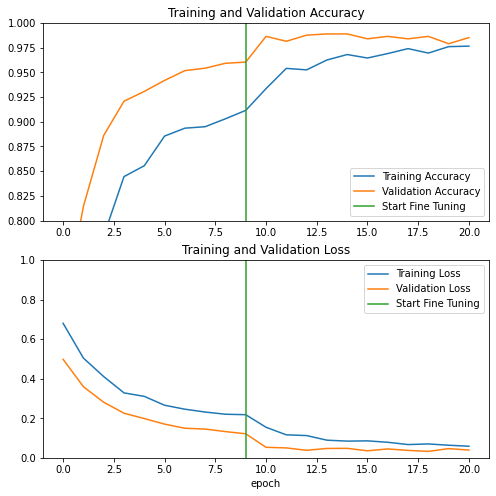

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/6 [====>.........................] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

5/6 [========================>.....] - ETA: 0s - loss: 0.0332 - accuracy: 0.9937

6/6 [==============================] - 0s 13ms/step - loss: 0.0281 - accuracy: 0.9948


Test accuracy : 0.9947916865348816


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0]
Labels:
 [0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0]


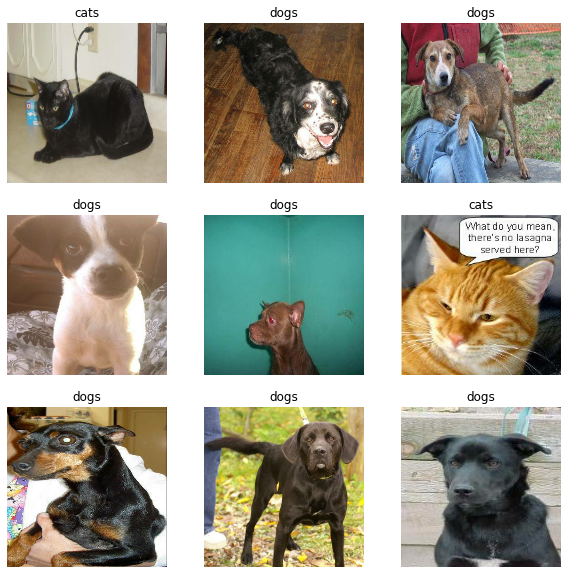

In [37]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
